## Feature Store

In [3]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
from time import gmtime, strftime
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup
import time
from botocore.exceptions import ClientError

boto_session = boto3.Session()
sagemaker_client = boto_session.client(service_name='sagemaker')
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime')

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

# set up S3 bucket
default_bucket = feature_store_session.default_bucket()
prefix = "predictive-maintenance-feature-store"

# load the data
s3_client = boto3.client('s3')
response = s3_client.get_object(Bucket=default_bucket, Key='root/AAI-540_Predictive-Maintenance-for-Pharmaceutical-Manufacturing-Equipment/resampled_predictive_maintenance_dataset.csv')
df = pd.read_csv(response['Body'])

print("Dataset loaded successfully. Shape:", df.shape)
print("\nFirst few rows of the dataset:")
print(df.head())

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Dataset loaded successfully. Shape: (248776, 12)

First few rows of the dataset:
       date    device  failure    metric1  metric2  metric3  metric4  metric5  \
0  1/1/2015  S1F01085        0  215630672       55        0       52        6   
1  1/1/2015  S1F0166B        0   61370680        0        3        0        6   
2  1/1/2015  S1F01E6Y        0  173295968        0        0        0       12   
3  1/1/2015  S1F01JE0        0   79694024        0        0        0        6   
4  1/1/2015  S1F01R2B        0  135970480        0        0        0       15   

   metric6  metric7  metric8  metric9  
0   407438        0        0        7  
1   403174        0        0        0  
2   237394        0        0        0  
3   410186        0        0        0  
4   313173        0        0       

## EDA

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# basic info
print(df.info())
print(df.describe())

# missing values
print("\nMissing values:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248776 entries, 0 to 248775
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     248776 non-null  object
 1   device   248776 non-null  object
 2   failure  248776 non-null  int64 
 3   metric1  248776 non-null  int64 
 4   metric2  248776 non-null  int64 
 5   metric3  248776 non-null  int64 
 6   metric4  248776 non-null  int64 
 7   metric5  248776 non-null  int64 
 8   metric6  248776 non-null  int64 
 9   metric7  248776 non-null  int64 
 10  metric8  248776 non-null  int64 
 11  metric9  248776 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 22.8+ MB
None
             failure       metric1        metric2        metric3  \
count  248776.000000  2.487760e+05  248776.000000  248776.000000   
mean        0.500000  1.247639e+08    2077.671287       7.159581   
std         0.500001  6.982472e+07    7770.676579     132.863925   
min         0.000000  0.0000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248776 entries, 0 to 248775
Data columns (total 12 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   date     248776 non-null  object
 1   device   248776 non-null  object
 2   failure  248776 non-null  int64 
 3   metric1  248776 non-null  int64 
 4   metric2  248776 non-null  int64 
 5   metric3  248776 non-null  int64 
 6   metric4  248776 non-null  int64 
 7   metric5  248776 non-null  int64 
 8   metric6  248776 non-null  int64 
 9   metric7  248776 non-null  int64 
 10  metric8  248776 non-null  int64 
 11  metric9  248776 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 22.8+ MB


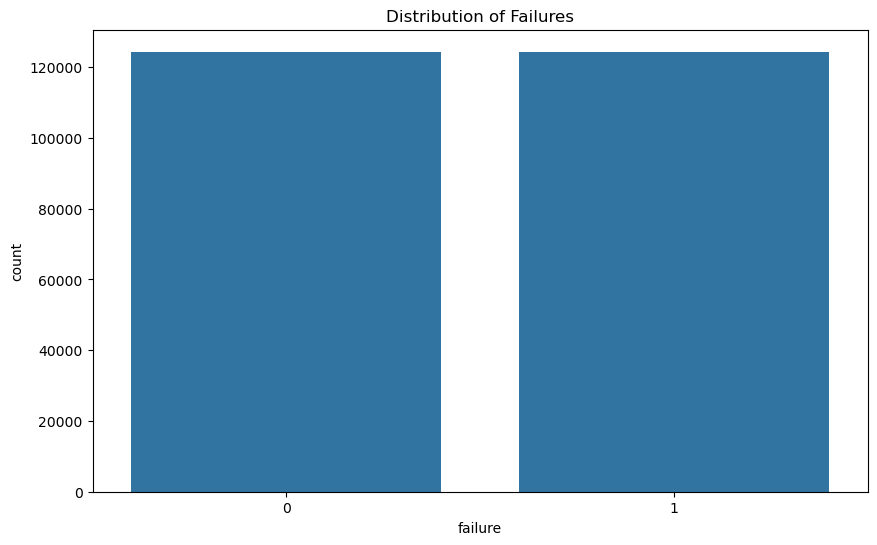

In [6]:
# Plot distribution of the target variable (failure)
plt.figure(figsize=(10, 6))
sns.countplot(x='failure', data=df)
plt.title('Distribution of Failures')
plt.show()

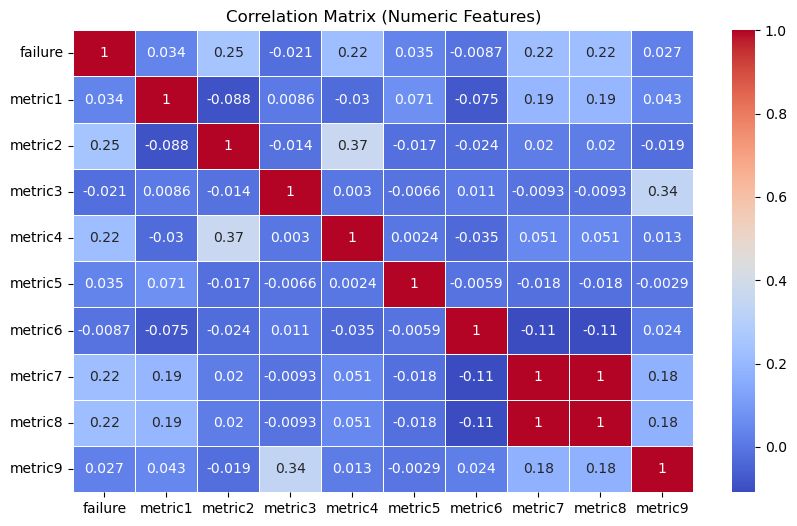

In [7]:
# Select only numeric columns for correlation matrix
numeric_columns = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_columns].corr()

# Plot correlation matrix for numeric columns
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (Numeric Features)')
plt.show()

### Failure Rate by device

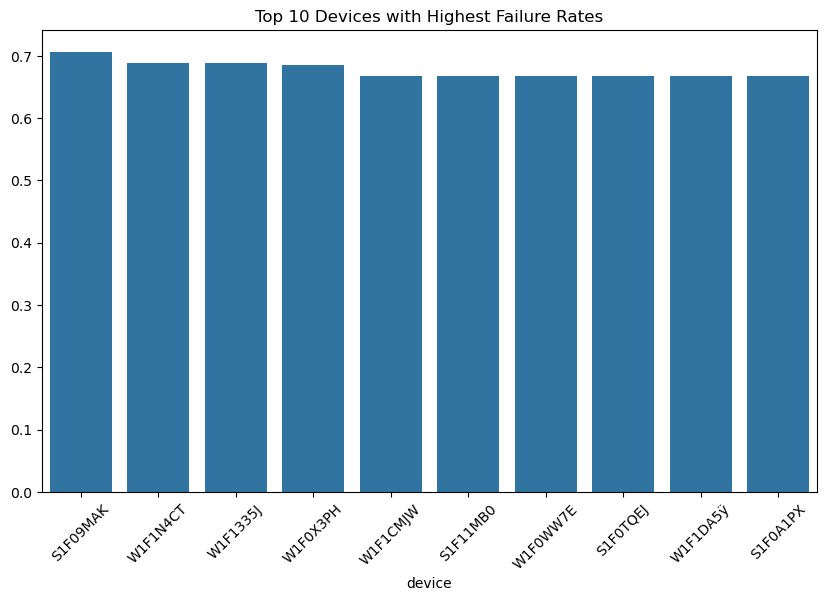

In [8]:
device_failure_rate = df.groupby('device')['failure'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=device_failure_rate.index[:10], y=device_failure_rate.values[:10])
plt.title('Top 10 Devices with Highest Failure Rates')
plt.xticks(rotation=45)
plt.show()

### Failures over time

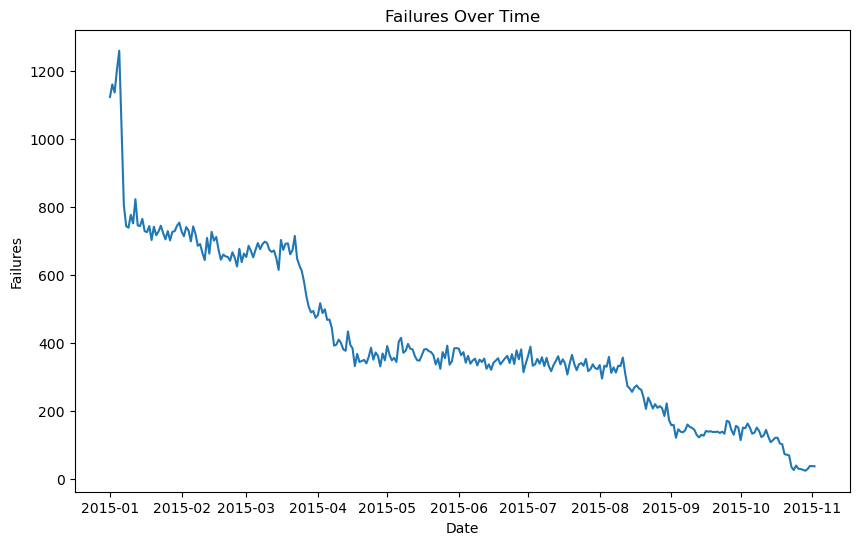

In [9]:
# Time series analysis for failures
df['date'] = pd.to_datetime(df['date'])
failures_over_time = df.groupby('date')['failure'].sum()
plt.figure(figsize=(10, 6))
plt.plot(failures_over_time.index, failures_over_time.values)
plt.title('Failures Over Time')
plt.xlabel('Date')
plt.ylabel('Failures')
plt.show()

### Failure vs Device Usage

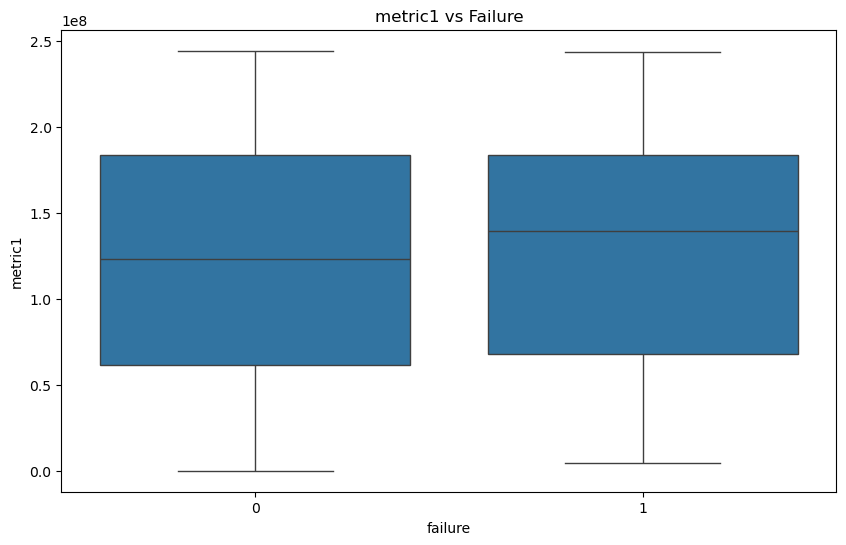

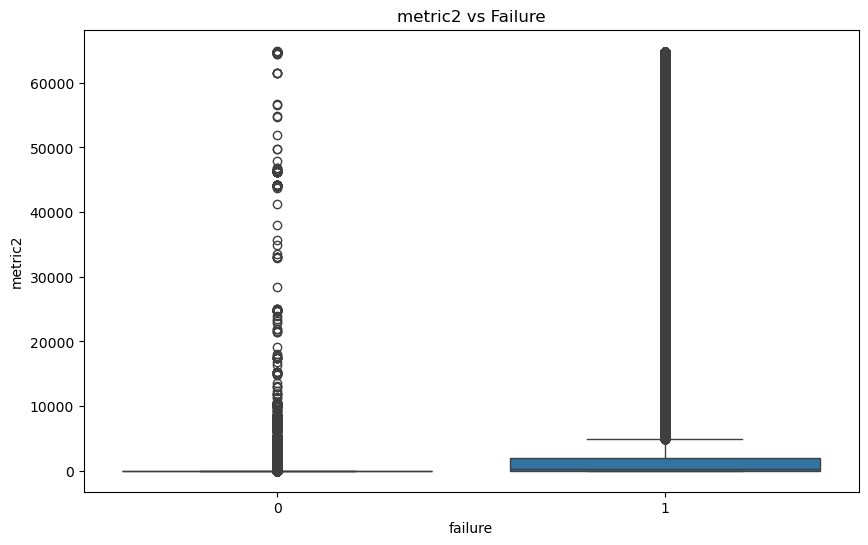

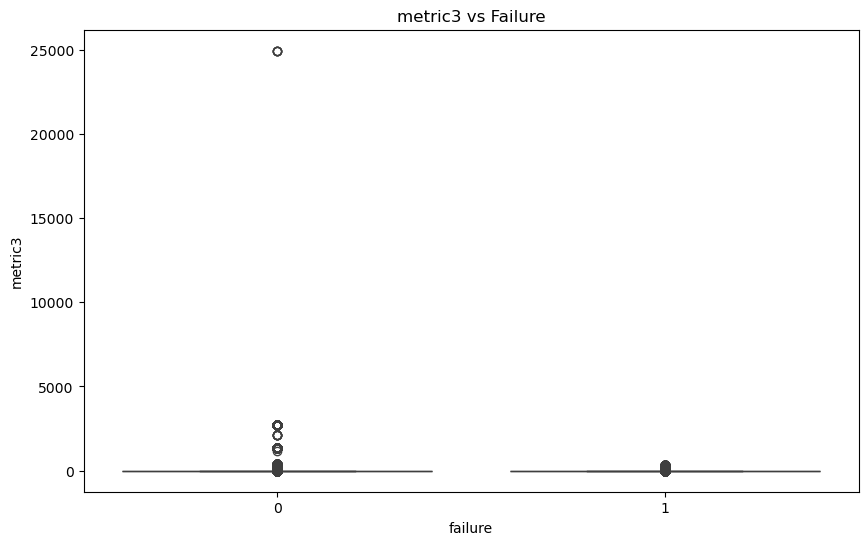

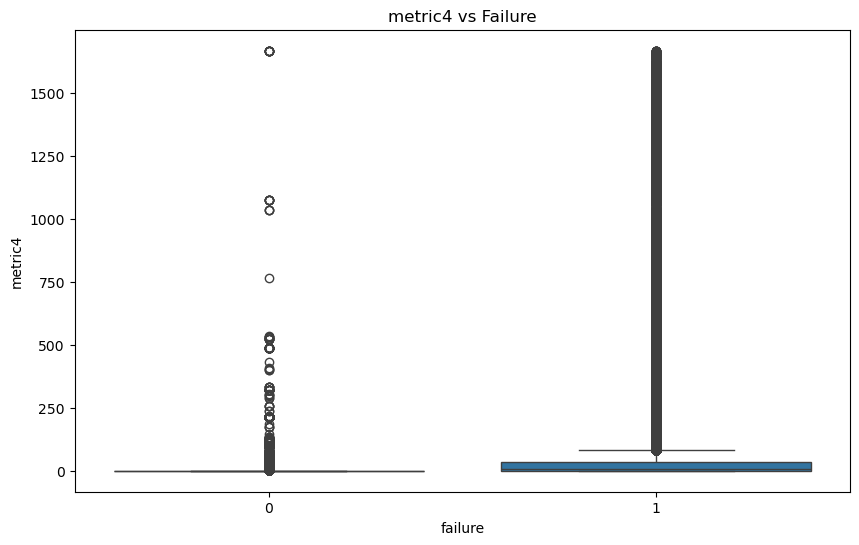

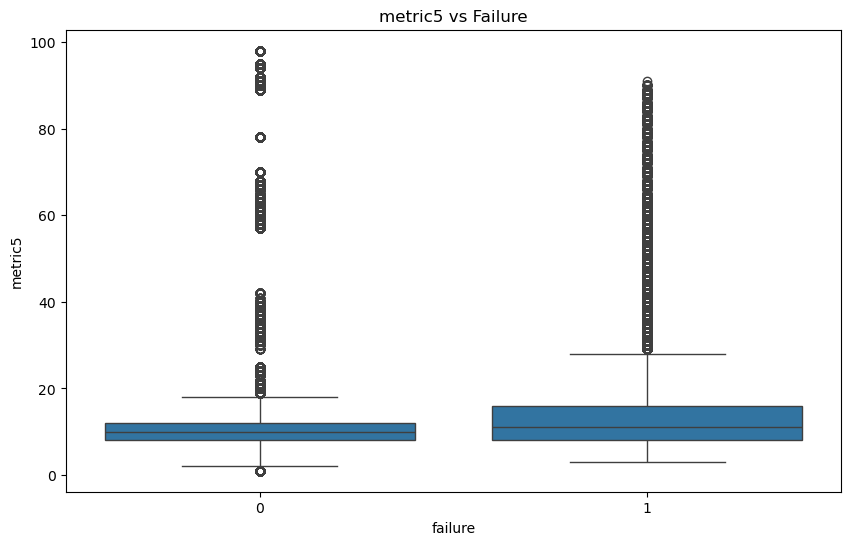

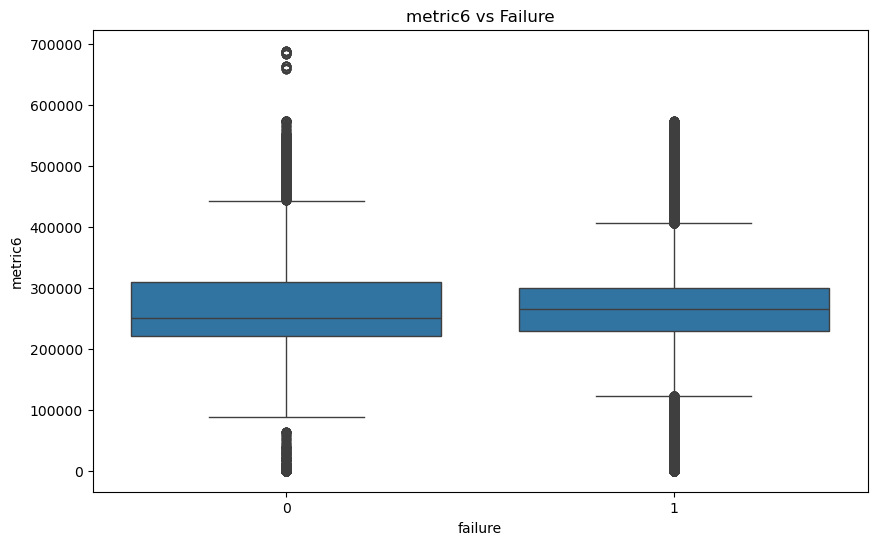

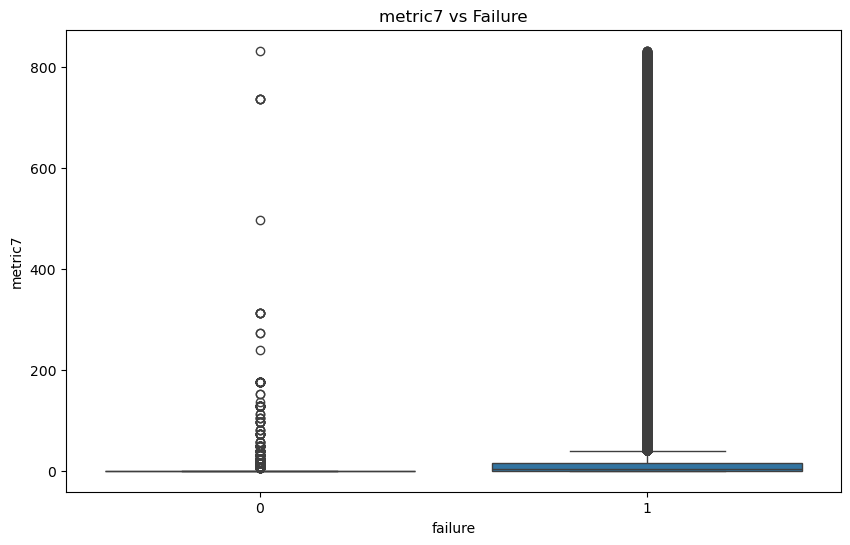

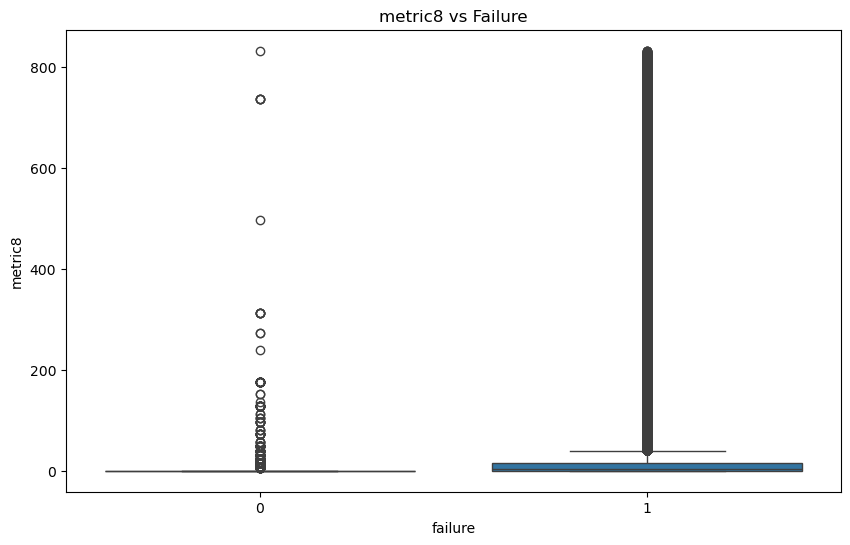

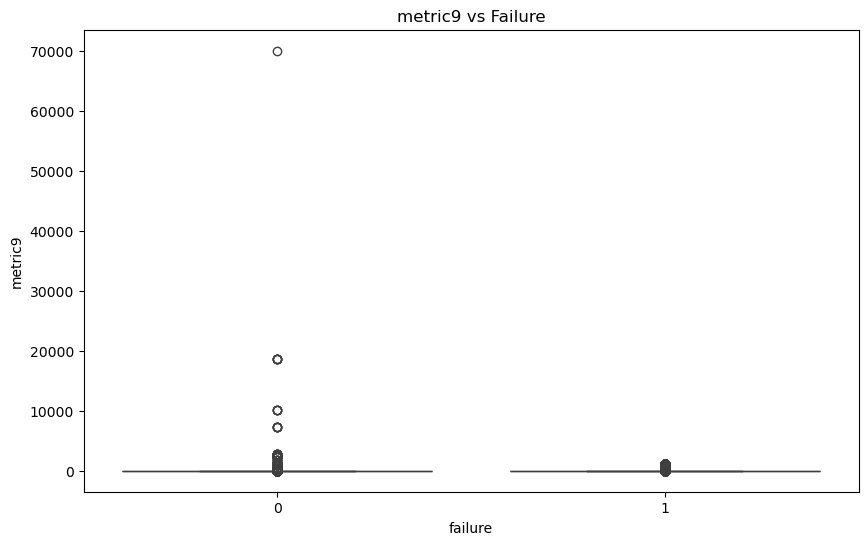

In [10]:
# List of all metric columns
metric_columns = ['metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9']

# Loop through each metric and plot boxplot against failure
for metric in metric_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='failure', y=metric, data=df)
    plt.title(f'{metric} vs Failure')
    plt.show()

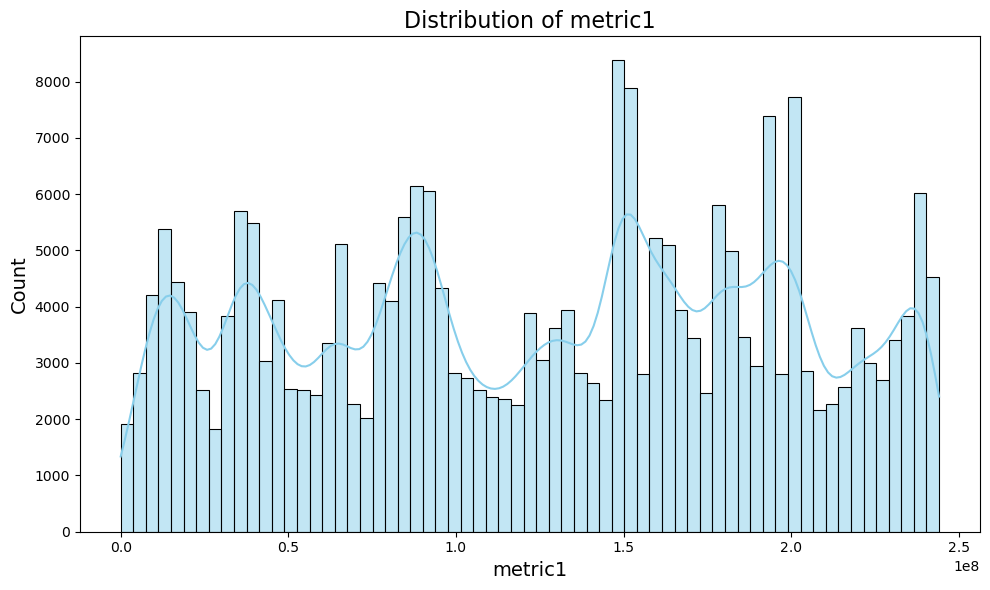

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the feature to plot
feature = 'metric1'

# Check if the feature exists in the dataset
if feature in df.columns:
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature '{feature}' not found in the dataset.")

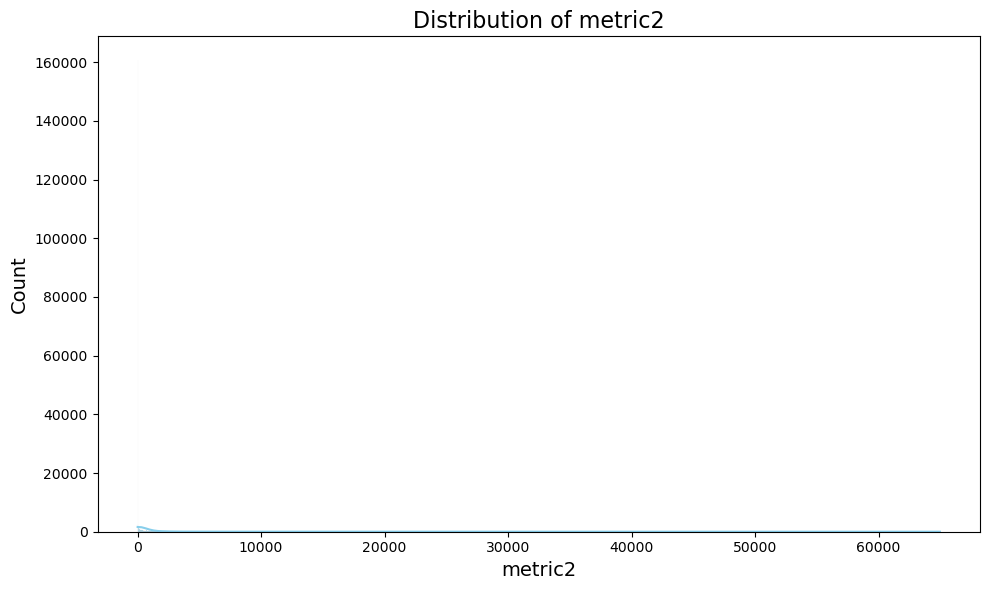

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the feature to plot
feature = 'metric2'

# Check if the feature exists in the dataset
if feature in df.columns:
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature '{feature}' not found in the dataset.")


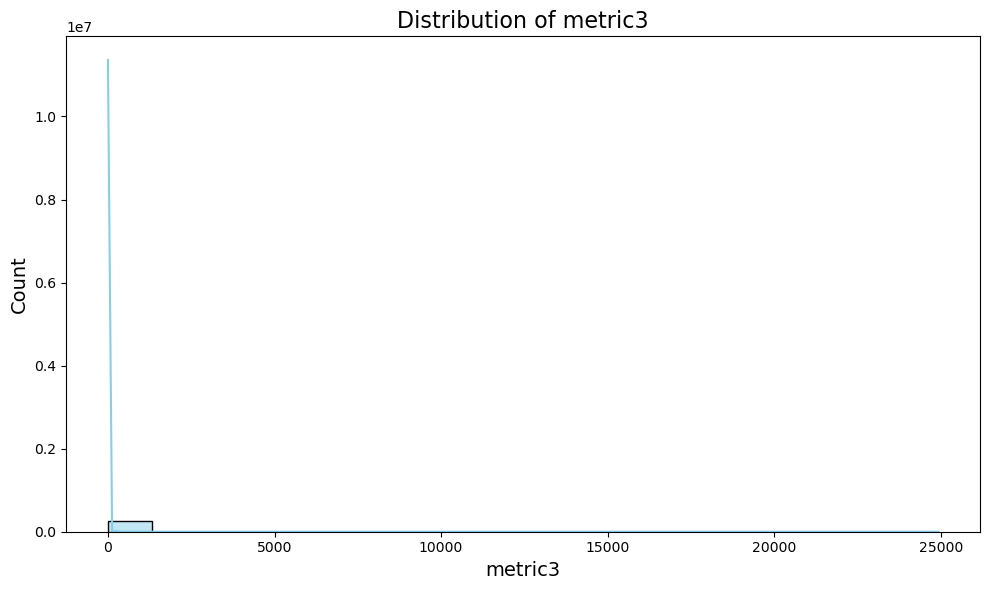

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the feature to plot
feature = 'metric3'

# Check if the feature exists in the dataset
if feature in df.columns:
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature '{feature}' not found in the dataset.")


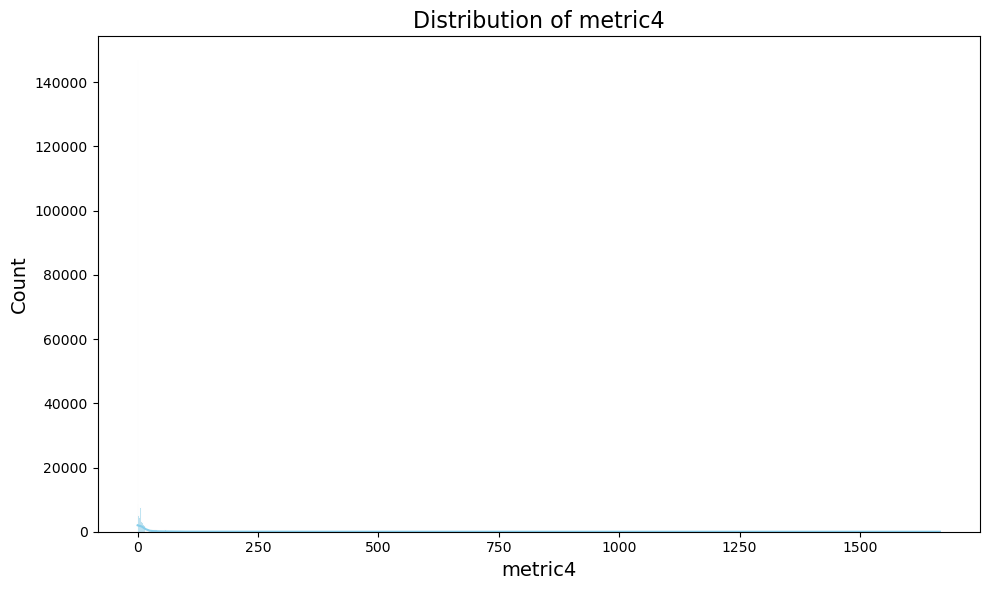

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the feature to plot
feature = 'metric4'

# Check if the feature exists in the dataset
if feature in df.columns:
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature '{feature}' not found in the dataset.")


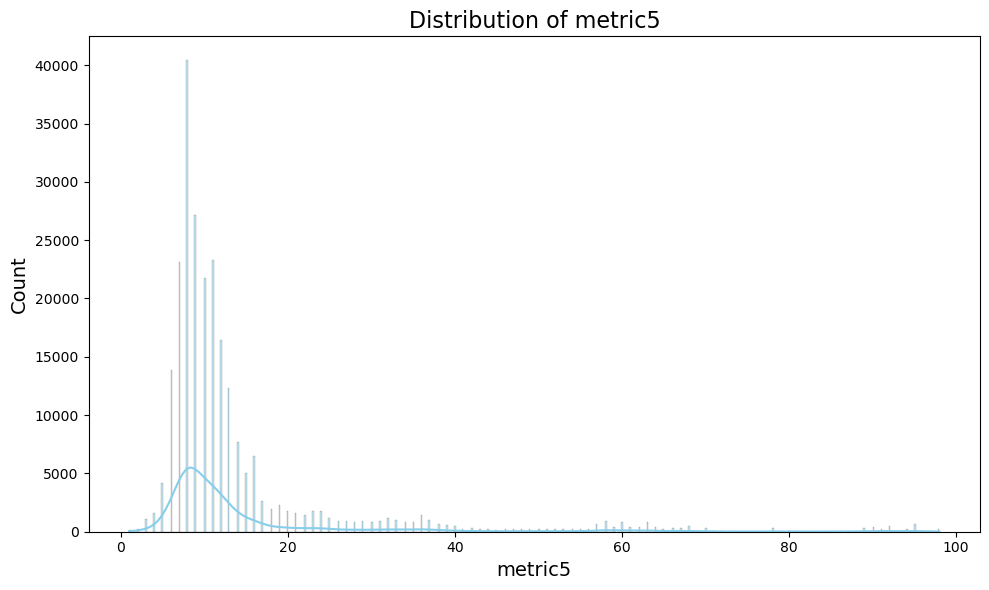

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the feature to plot
feature = 'metric5'

# Check if the feature exists in the dataset
if feature in df.columns:
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature '{feature}' not found in the dataset.")


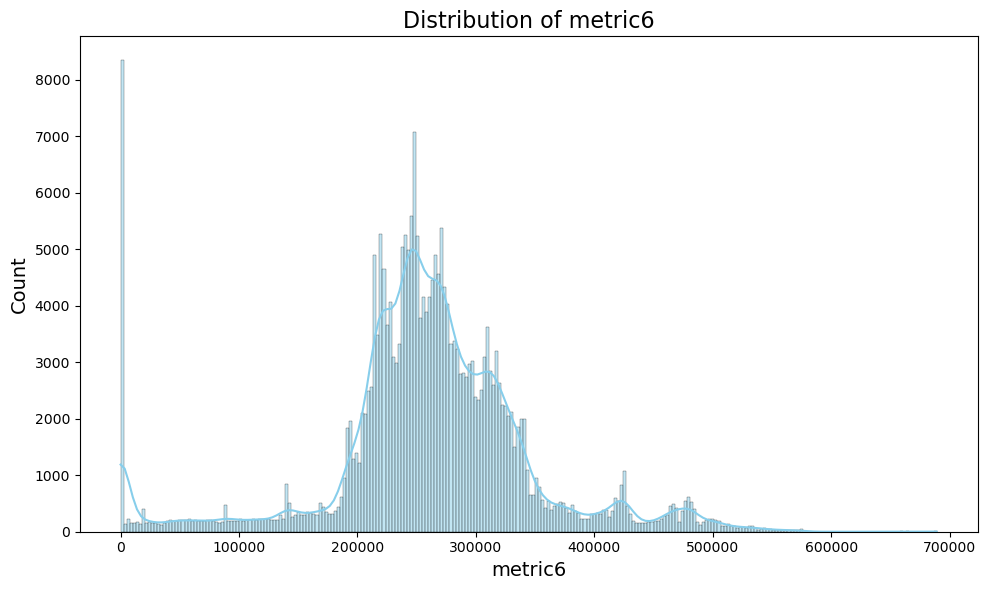

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the feature to plot
feature = 'metric6'

# Check if the feature exists in the dataset
if feature in df.columns:
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature '{feature}' not found in the dataset.")


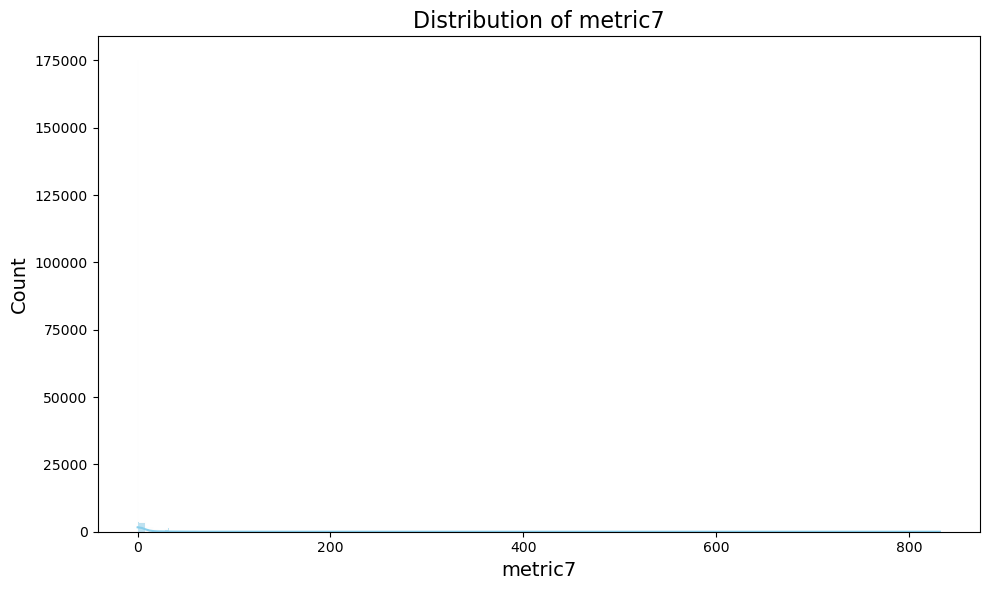

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the feature to plot
feature = 'metric7'

# Check if the feature exists in the dataset
if feature in df.columns:
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature '{feature}' not found in the dataset.")


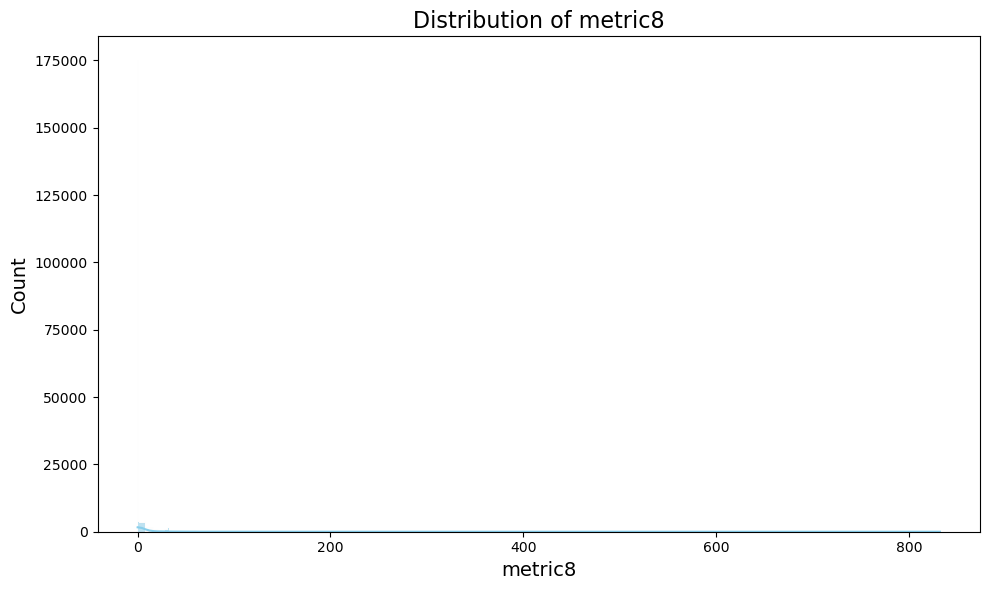

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the feature to plot
feature = 'metric8'

# Check if the feature exists in the dataset
if feature in df.columns:
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature '{feature}' not found in the dataset.")


## Feature Engineering

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def clean_feature_eng(df):
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract time-based features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    
    # Handle highly skewed metrics (log transform)
    skewed_metrics = ['metric2', 'metric3', 'metric4', 'metric7', 'metric8', 'metric9']
    for metric in skewed_metrics:
        df[f'{metric}_log'] = np.log1p(df[metric])
    
    # Create simple aggregated features for each device
    device_aggs = df.groupby('device').agg({
        'metric1': ['mean'],
        'metric5': ['mean'],
        'metric6': ['mean']
    })
    device_aggs.columns = ['_'.join(col).strip() for col in device_aggs.columns.values]
    df = df.merge(device_aggs, on='device', how='left')
    
    # Encode categorical variables
    df['device'] = pd.factorize(df['device'])[0]
    
    # Normalize numerical features
    scaler = StandardScaler()
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    # Drop the original date column
    df = df.drop('date', axis=1)
    
    # Add EventTime and RecordId
    current_time_sec = int(round(time.time()))
    df['EventTime'] = pd.Series([current_time_sec] * len(df), dtype='float64')
    df['RecordId'] = df.index.astype(str)
    
    return df

In [20]:
df_engineered = clean_feature_eng(df)

# Verify the results
print(df_engineered.info())
print("\nMissing values:")
print(df_engineered.isnull().sum())
print("\nFirst few rows:")
print(df_engineered.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248776 entries, 0 to 248775
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   device        248776 non-null  float64
 1   failure       248776 non-null  float64
 2   metric1       248776 non-null  float64
 3   metric2       248776 non-null  float64
 4   metric3       248776 non-null  float64
 5   metric4       248776 non-null  float64
 6   metric5       248776 non-null  float64
 7   metric6       248776 non-null  float64
 8   metric7       248776 non-null  float64
 9   metric8       248776 non-null  float64
 10  metric9       248776 non-null  float64
 11  year          248776 non-null  int32  
 12  month         248776 non-null  int32  
 13  day           248776 non-null  int32  
 14  dayofweek     248776 non-null  int32  
 15  metric2_log   248776 non-null  float64
 16  metric3_log   248776 non-null  float64
 17  metric4_log   248776 non-null  float64
 18  metr

In [21]:
current_time_sec = int(round(time.time()))
df_engineered['EventTime'] = pd.Series([current_time_sec] * len(df_engineered), dtype='float64')
df_engineered['RecordId'] = df_engineered.index.astype(str)

In [22]:
from sagemaker.feature_store.feature_group import FeatureGroup
from time import gmtime, strftime

# Define Feature Groups with unique names
device_feature_group_name = "device-feature-group-" + strftime("%d-%H-%M-%S", gmtime())
metrics_feature_group_name = "metrics-feature-group-" + strftime("%d-%H-%M-%S", gmtime())

# Create FeatureGroup objects
device_feature_group = FeatureGroup(
    name=device_feature_group_name,
    sagemaker_session=feature_store_session
)

metrics_feature_group = FeatureGroup(
    name=metrics_feature_group_name,
    sagemaker_session=feature_store_session
)

In [23]:
# Prepare device features
device_features = df_engineered[['RecordId', 'EventTime', 'device', 'metric1_mean', 'metric5_mean', 'metric6_mean']].copy()

# Prepare metrics features
metrics_features = df_engineered[['RecordId', 'EventTime', 'device', 'failure', 'metric1', 'metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7', 'metric8', 'metric9',
                                  'year', 'month', 'day', 'dayofweek',
                                  'metric2_log', 'metric3_log', 'metric4_log', 'metric7_log', 'metric8_log', 'metric9_log']].copy()

# Load feature definitions
device_feature_group.load_feature_definitions(data_frame=device_features)
metrics_feature_group.load_feature_definitions(data_frame=metrics_features)

print(f"Device Feature Group: {device_feature_group.name} loaded with features.")
print(f"Metrics Feature Group: {metrics_feature_group.name} loaded with features.")

Device Feature Group: device-feature-group-22-01-37-32 loaded with features.
Metrics Feature Group: metrics-feature-group-22-01-37-32 loaded with features.


In [24]:
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

In [25]:
# Create Feature Groups 
device_feature_group.create(
    s3_uri=f"s3://{default_bucket}/sagemaker-featurestore-predictive-maintenance/device_features",
    record_identifier_name="RecordId",
    event_time_feature_name="EventTime",
    role_arn=sagemaker.get_execution_role(),
    enable_online_store=True
)

metrics_feature_group.create(
    s3_uri=f"s3://{default_bucket}/sagemaker-featurestore-predictive-maintenance/metrics_features",
    record_identifier_name="RecordId",
    event_time_feature_name="EventTime",
    role_arn=sagemaker.get_execution_role(),
    enable_online_store=True
)

# Wait for Feature Group creation to complete
wait_for_feature_group_creation_complete(device_feature_group)
wait_for_feature_group_creation_complete(metrics_feature_group)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup device-feature-group-22-01-37-32 successfully created.
Waiting for Feature Group Creation
FeatureGroup metrics-feature-group-22-01-37-32 successfully created.


### Takes about 20 mins. Can play around with batch size

In [26]:
def batch_ingest(feature_group, data_frame, batch_size=1000):
   num_records = len(data_frame)
   for i in range(0, num_records, batch_size):
       batch = data_frame.iloc[i:i+batch_size]
       feature_group.ingest(data_frame=batch, max_workers=10, wait=True)
       print(f"Ingested {i+batch_size} records out of {num_records}")
       time.sleep(1)

# Use the function
batch_ingest(device_feature_group, device_features)
batch_ingest(metrics_feature_group, metrics_features)

Ingested 1000 records out of 248776
Ingested 2000 records out of 248776
Ingested 3000 records out of 248776
Ingested 4000 records out of 248776
Ingested 5000 records out of 248776
Ingested 6000 records out of 248776
Ingested 7000 records out of 248776
Ingested 8000 records out of 248776
Ingested 9000 records out of 248776
Ingested 10000 records out of 248776
Ingested 11000 records out of 248776
Ingested 12000 records out of 248776
Ingested 13000 records out of 248776
Ingested 14000 records out of 248776
Ingested 15000 records out of 248776
Ingested 16000 records out of 248776
Ingested 17000 records out of 248776
Ingested 18000 records out of 248776
Ingested 19000 records out of 248776
Ingested 20000 records out of 248776
Ingested 21000 records out of 248776
Ingested 22000 records out of 248776
Ingested 23000 records out of 248776
Ingested 24000 records out of 248776
Ingested 25000 records out of 248776
Ingested 26000 records out of 248776
Ingested 27000 records out of 248776
Ingested 2

In [27]:
# Setup clients
sagemaker_client = boto3.client('sagemaker')
s3_client = boto3.client('s3')

def verify_feature_group(feature_group_name):
    # Describe the feature group
    response = sagemaker_client.describe_feature_group(FeatureGroupName=feature_group_name)
    print(f"Feature Group {feature_group_name} status: {response['FeatureGroupStatus']}")
    
    if 'OfflineStoreConfig' in response:
        offline_config = response['OfflineStoreConfig']
        if 'TotalRecordCount' in offline_config:
            print(f"Number of records: {offline_config['TotalRecordCount']}")
        else:
            print("Total record count not available. The offline store might still be processing.")
        
        # Get the S3 URI for the offline store
        s3_uri = offline_config['S3StorageConfig']['ResolvedOutputS3Uri']
        print(f"Offline store S3 URI: {s3_uri}")
        return s3_uri
    else:
        print("Offline store not configured for this Feature Group.")
        return None

In [28]:
# Verify device feature group
print("Verifying Device Feature Group:")
device_s3_uri = verify_feature_group(device_feature_group_name)

Verifying Device Feature Group:
Feature Group device-feature-group-22-01-37-32 status: Created
Total record count not available. The offline store might still be processing.
Offline store S3 URI: s3://sagemaker-us-east-1-807494057176/sagemaker-featurestore-predictive-maintenance/device_features/807494057176/sagemaker/us-east-1/offline-store/device-feature-group-22-01-37-32-1729561060/data


In [29]:
def list_s3_files(bucket, prefix, max_files=10):
    s3 = boto3.client('s3')
    response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix, MaxKeys=max_files)
    
    print(f"Contents of s3://{bucket}/{prefix}:")
    if 'Contents' in response:
        for obj in response['Contents']:
            print(f"- {obj['Key']}")
    else:
        print("No files found.")

# Use the S3 URI from your feature group
device_s3_uri = device_feature_group.describe()['OfflineStoreConfig']['S3StorageConfig']['ResolvedOutputS3Uri']
bucket = device_s3_uri.split('/')[2]
prefix = '/'.join(device_s3_uri.split('/')[3:])

list_s3_files(bucket, prefix)

Contents of s3://sagemaker-us-east-1-807494057176/sagemaker-featurestore-predictive-maintenance/device_features/807494057176/sagemaker/us-east-1/offline-store/device-feature-group-22-01-37-32-1729561060/data:
- sagemaker-featurestore-predictive-maintenance/device_features/807494057176/sagemaker/us-east-1/offline-store/device-feature-group-22-01-37-32-1729561060/data/year=2024/month=10/day=22/hour=01/20241022T013732Z_03Ivhp6meXm6eNWL.parquet
- sagemaker-featurestore-predictive-maintenance/device_features/807494057176/sagemaker/us-east-1/offline-store/device-feature-group-22-01-37-32-1729561060/data/year=2024/month=10/day=22/hour=01/20241022T013732Z_0kyGAFYQeIsfPiMa.parquet
- sagemaker-featurestore-predictive-maintenance/device_features/807494057176/sagemaker/us-east-1/offline-store/device-feature-group-22-01-37-32-1729561060/data/year=2024/month=10/day=22/hour=01/20241022T013732Z_10zTQMDZiEmVXKnr.parquet
- sagemaker-featurestore-predictive-maintenance/device_features/807494057176/sagema

In [30]:
def delete_feature_group_if_exists(feature_group):
    try:
        feature_group.delete()
        print(f"Deleting FeatureGroup {feature_group.name}")
        print(f"FeatureGroup {feature_group.name} successfully deleted.")
    except ClientError as e:
        if e.response['Error']['Code'] == 'ResourceNotFound':
            print(f"FeatureGroup {feature_group.name} does not exist. Skipping deletion.")
        else:
            raise
delete_feature_group_if_exists(device_feature_group)
delete_feature_group_if_exists(metrics_feature_group)

Deleting FeatureGroup device-feature-group-22-01-37-32
FeatureGroup device-feature-group-22-01-37-32 successfully deleted.
Deleting FeatureGroup metrics-feature-group-22-01-37-32
FeatureGroup metrics-feature-group-22-01-37-32 successfully deleted.


In [31]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>